In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import hankel
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData

### Functions

In [43]:
def compute_smooth_temporal_basis(type,nBases,duration):
    nkbins = duration
    ttb = np.array([np.arange(1,nkbins+1).tolist()]*nBases).T # time indices for basis
    if type == 'raised cosine':
        # spacing between the centers must be 1/4 of the with of the cosine
        dbcenter = nkbins / (3 + nBases) # spacing between bumps
        width = 4 * dbcenter # width of each bump
        bcenters = 2 * dbcenter + dbcenter*np.array(0,nBases)
        x=ttb-np.array([bcenters.tolist()]*10)
        period=width
        basis = (abs(x/period)<0.5)*(np.cos(x*2*np.pi/period)*.5+.5)
    elif type == 'boxcar':
        width = nkbins / nBases
        basis = np.zeros(np.shape(ttb))
        bcenters = width * np.arange(1,nBases+1) - width/2
        for k in np.arange(0,nBases):
            idx = np.logical_and(ttb[:, k] > np.round(width * k) , ttb[:, k] <= np.round(width * (k+1)))
            basis[idx, k] = 1 / sum(idx)
                
    edim=basis.shape[1]
    return basis,edim

### Analysis

In [2]:
# Load data
neu_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/2023-11-28_11-15-50_Riesling_v4_e1_r1_good2_neu.h5"
eye_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/eye/2023-11-28_11-15-50_Riesling_e1_r1_eye.h5"
sp_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/spikes/2023-11-28_11-15-50_Riesling_v4_e1_r1_sp.h5"
bhv_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/bhv/2023-11-28_11-15-50_Riesling_e1_r1_bhv.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)
#eye_data = EyeData.from_python_hdf5(eye_path)
sp_data = SpikeData.from_python_hdf5(sp_path)
bhv_data = BhvData.from_python_hdf5(bhv_path)

In [3]:
all_sp = sp_data.sp_samples[neu_data.cluster_array_pos]
all_sp.shape

(4995471,)

In [4]:
# ---------- create stimulus vector for sample o1_c1
# select one trial
tr =5
o1_c1_trials = np.where(np.logical_and(np.logical_and(bhv_data.sample_id==51,bhv_data.trial_error==0),bhv_data.pos_code==1))[0]
codes = bhv_data.code_numbers[o1_c1_trials[tr]]
s_on_idx=np.where(codes==23)[0]
s_off_idx = np.where(codes==24)[0]
st_trial_idx = np.where(codes==9)[0]
end_trial_idx = np.where(codes==18)[0]
s_on = bhv_data.code_samples[o1_c1_trials[tr],s_on_idx]
s_off = bhv_data.code_samples[o1_c1_trials[tr],s_off_idx]
st_trial = s_on-200#bhv_data.code_samples[o1_c1_trials[tr],st_trial_idx]
end_trial = s_off +(1200-450)#bhv_data.code_samples[o1_c1_trials[tr],end_trial_idx]
# create stim vector
stim = np.zeros((int(end_trial-st_trial)))-0.5
stim[int(s_on-st_trial):int(s_off-st_trial)]=0.5
#stim[int(s_on-st_trial)]=0.5

In [5]:
o1_c1_trials = np.where(np.logical_and(np.logical_and(bhv_data.sample_id==51,bhv_data.trial_error==0),bhv_data.pos_code==1))[0]
st = bhv_data.code_samples[o1_c1_trials[0],0]-1000
sp = all_sp[int(st):]

codes = bhv_data.code_numbers[o1_c1_trials]
s_on_idx=np.where(codes==23)
# s_off_idx = np.where(codes==24)
# st_trial_idx = np.where(codes==9)
# end_trial_idx = np.where(codes==18)
s_on = bhv_data.code_samples[o1_c1_trials][s_on_idx]-int(st)
s_off = s_on +450
stim = np.zeros(len(sp))-0.5
for start_s, end_s in zip(s_on,s_off):
    stim[int(start_s):int(end_s)]=0.5

In [6]:
sp.shape

(4916180,)

In [7]:
stim.shape

(4916180,)

In [8]:
bhv_data.code_numbers[o1_c1_trials][14]

array([ 9.,  7., 35.,  8., 23., 24., 25., 26., 27., 28., 29.,  4., 36.,
       30., 96., 18., nan, nan])

In [9]:
# -------- select spikes during the trial
trial_sp= sp# all_sp[int(st_trial):int(end_trial)]
# ------ Bin the spike trains
dt_bin = 1
rest = len(trial_sp)%dt_bin
if rest>0:
    trial_sp = trial_sp[:-rest]
dt_bin_split = trial_sp.shape[0]/dt_bin
sp_binned = np.sum(np.array(np.split(trial_sp,dt_bin_split)),axis=1)
# downsample stim
#stim_ds = stim[np.arange(0,len(stim)-dt_bin,dt_bin)]
stim_ds = stim[np.arange(0,len(stim),dt_bin)]
stim_ds.shape

(4916180,)

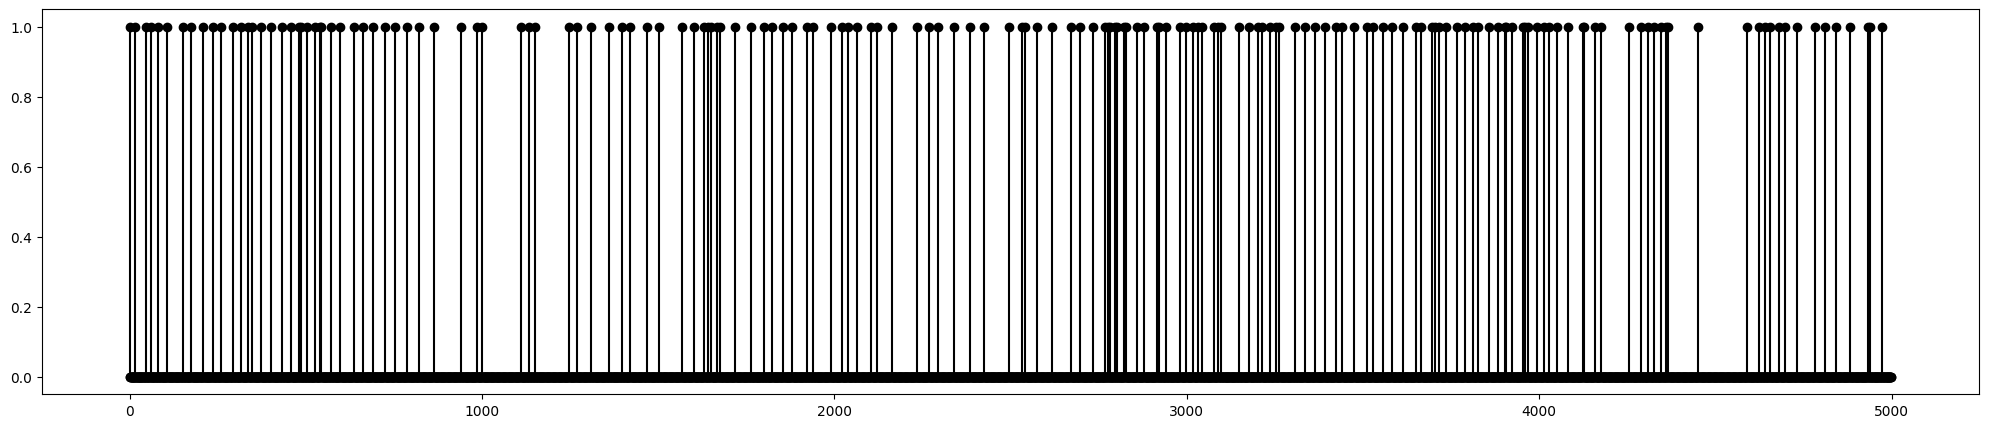

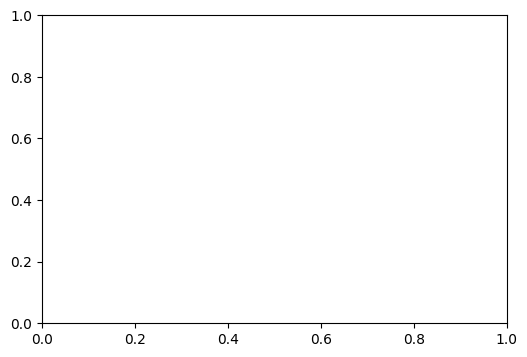

In [10]:
# ------- Plot spikes and correlation
f,ax = plt.subplots(figsize=(25,5))
markerline,_,_ = ax.stem( sp_binned[:5000], linefmt='k-', basefmt='k-', label='spikes')
#ax.vlines([int((s_on-st_trial)/dt_bin),int((s_off-st_trial)/dt_bin)],[0],[2])
f,ax = plt.subplots(figsize=(6,4))
num_lags = 30 # number of time-lags to use 
#_=plt.xcorr(sp_binned, sp_binned, maxlags=num_lags, usevlines=False, marker='.', linestyle='-')

<Figure size 640x480 with 0 Axes>

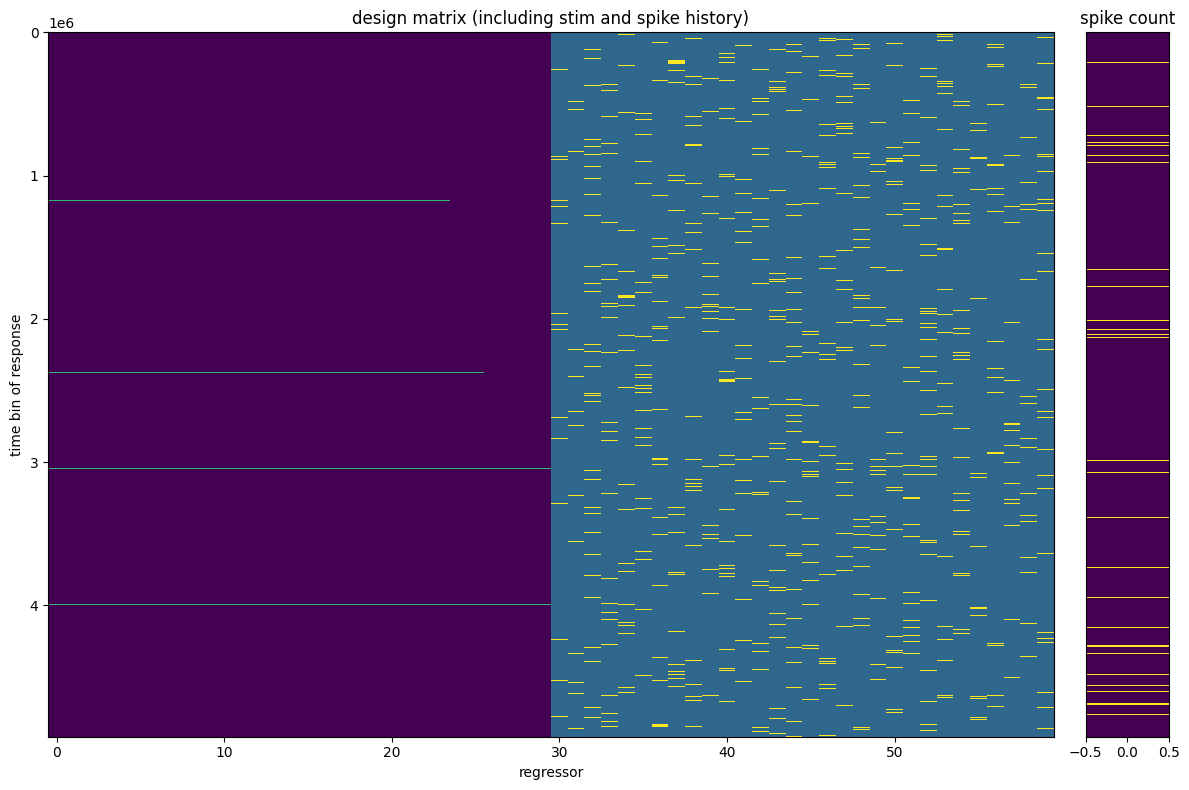

In [11]:
# ---------Build design matrix: single-neuron GLM with spike-history


# Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 30     
# Set number of time bins of auto-regressive spike-history to use
nthist = 30

# Build stimulus design matrix 
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_ds))   # pad early bins of stimulus with zero
design_mat_stim = hankel(padded_stim[:-ntfilt+1], stim_ds[-ntfilt:])

# Build spike-history design matrix
padded_spikes = np.hstack((np.zeros(nthist), sp_binned[:-1]))
# SUPER important: note that this doesn't include the spike count for the
# bin we're predicting? The spike train is shifted by one bin (back in
# time) relative to the stimulus design matrix
design_mat_spikes = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])

# Combine these into a single design matrix
design_mat = np.concatenate((design_mat_stim, design_mat_spikes), axis=1)

# Let's visualize the design matrix just to see what it looks like
plt.clf()
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(design_mat, aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(sp_binned[:,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')

plt.tight_layout()
plt.show()

# The left part of the design matrix has the stimulus values, the right
# part has the spike-history values.  The image on the right is the spike
# count to be predicted.  Note that the spike-history portion of the design
# matrix had better be shifted so that we aren't allowed to use the spike
# count on this time bin to predict itself!

In [12]:

### === 4. fit single-neuron GLM with spike-history ==================

# Package available for download from
# https://www.statsmodels.org/stable/install.html
import statsmodels.api as sm
num_time_bins = stim_ds.size
design_mat_stim_offset = np.hstack((np.ones((num_time_bins,1)), design_mat_stim))     # just add a column of ones
# First fit GLM with no spike-history
print('Now fitting basic Poisson GLM...');
pGLM_model = sm.GLM(endog=sp_binned, exog=design_mat_stim_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
pGLM_results = pGLM_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

design_mat_offset = np.hstack((np.ones((num_time_bins,1)), design_mat))
# Then fit GLM with spike history (now use Xdsgn design matrix instead of Xstim)
print('Now fitting Poisson GLM with spike-history...')
pGLMsh_model = sm.GLM(endog=sp_binned, exog=design_mat_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
pGLMsh_results = pGLMsh_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLMsh_const = pGLMsh_results.params[0]
pGLMsh_filt = pGLMsh_results.params[1:ntfilt+1] # stimulus filter
pGLMsh_hist_filt = pGLMsh_results.params[ntfilt+1:] # spike history filter

Now fitting basic Poisson GLM...
Now fitting Poisson GLM with spike-history...


: 

In [ ]:
pGLM_filt.shape

(30,)

<Figure size 640x480 with 0 Axes>

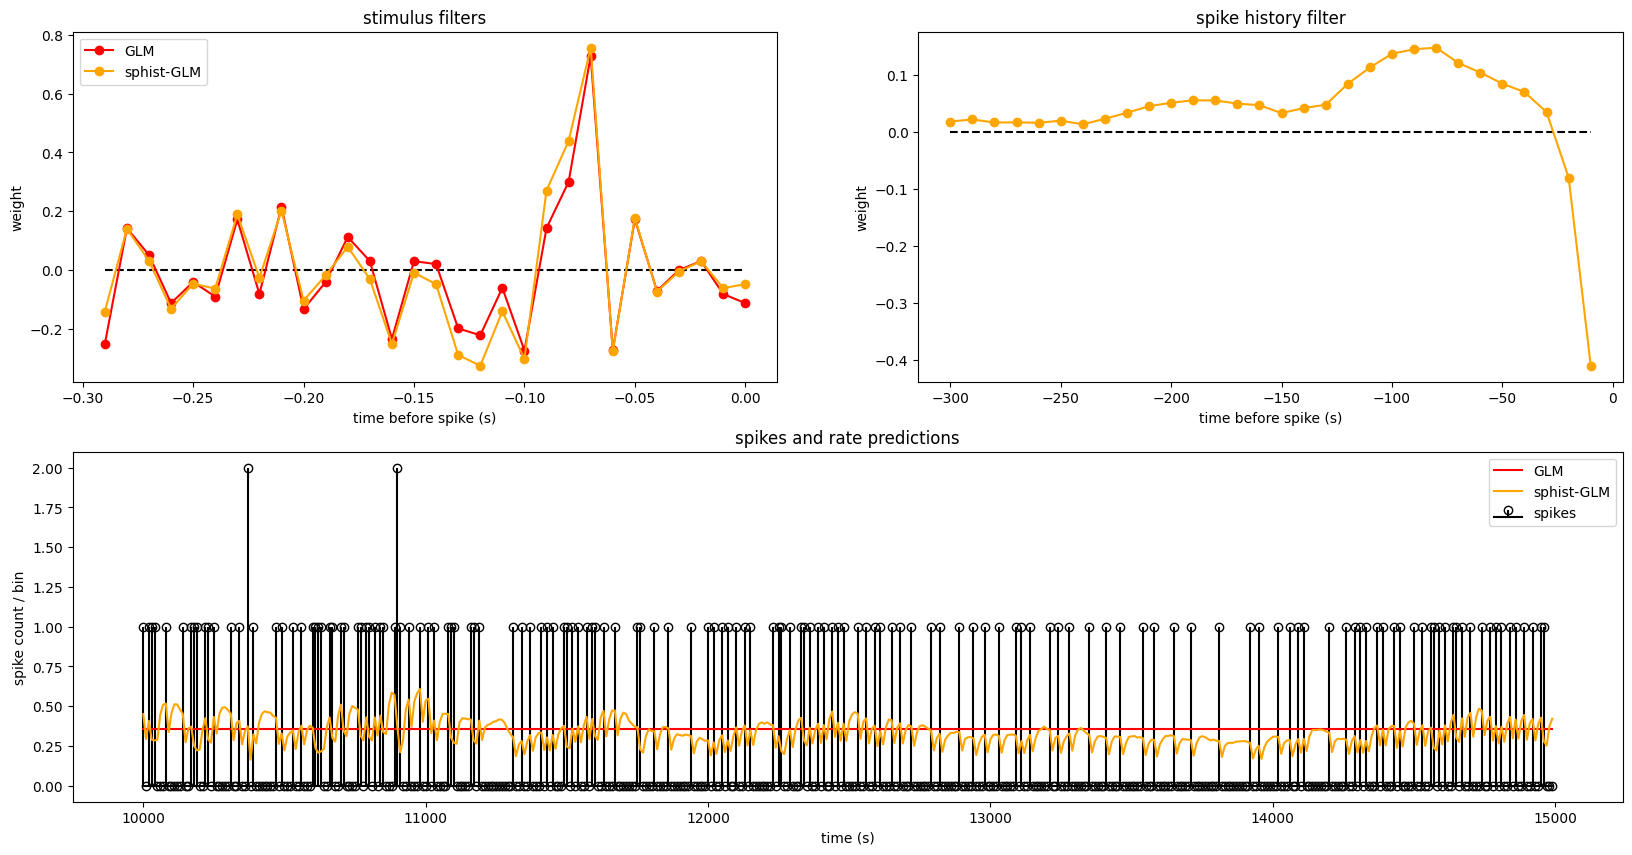

In [ ]:
#  Make plots comparing filters
dt_stim=dt_bin
ttk = np.arange(-1*ntfilt+1,1)*dt_stim/1000 # time bins for stim filter
tth = np.arange(-1*nthist,0)*dt_stim # time bins for spike-history filter

plt.clf()
fig = plt.figure(figsize=[20,10])
plt.subplot(221) # Plot stim filters
plt.plot(ttk,ttk*0, linestyle='--', c='k')
plt.plot(ttk,pGLM_filt, 'ro-', label='GLM')
plt.plot(ttk,pGLMsh_filt, 'o-', c='orange', label='sphist-GLM')
plt.legend(loc='upper left')
plt.title('stimulus filters')
plt.ylabel('weight')
plt.xlabel('time before spike (s)')

plt.subplot(222); # Plot spike history filter
plt.plot(tth,tth*0, linestyle='--', c='k')
plt.plot(tth,pGLMsh_hist_filt, 'o-', c='orange')
plt.title('spike history filter')
plt.xlabel('time before spike (s)')
plt.ylabel('weight')

### Plot predicted rate out of the two models

# Compute predicted spike rate on training data
rate_pred = np.exp(pGLM_const + design_mat_stim@pGLM_filt)
rate_pred_sh = np.exp(pGLMsh_const + design_mat@ pGLMsh_results.params[1:])

# Make plot
iiplot = np.arange(1000,1500)
ttplot = iiplot*dt_stim
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, sp_binned[iiplot], linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
plt.plot(ttplot, rate_pred[iiplot], c='r', label ='GLM')
plt.plot(ttplot, rate_pred_sh[iiplot], c='orange', label='sphist-GLM')
plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()